<a href="https://colab.research.google.com/github/Maple127/public127.github.io/blob/main/chapter_linear-regression/linear-regression-concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install -U d2l
from d2l import torch as d2l

# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Deep learning has witnessed a sort of Cambrian explosion
over the past decade.
The sheer number of techniques, applications and algorithms by far surpasses the
progress of previous decades.
This is due to a fortuitous combination of multiple factors,
one of which is the powerful free tools
offered by a number of open-source deep learning frameworks.
Theano :cite:`Bergstra.Breuleux.Bastien.ea.2010`,
DistBelief :cite:`Dean.Corrado.Monga.ea.2012`,
and Caffe :cite:`Jia.Shelhamer.Donahue.ea.2014`
arguably represent the
first generation of such models
that found widespread adoption.
In contrast to earlier (seminal) works like
SN2 (Simulateur Neuristique) :cite:`Bottou.Le-Cun.1988`,
which provided a Lisp-like programming experience,
modern frameworks offer automatic differentiation
and the convenience of Python.
These frameworks allow us to automate and modularize
the repetitive work of implementing gradient-based learning algorithms.

In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) automatic differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.
In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


In [2]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad of the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if you spent a month reinventing the wheel.

For standard operations,
we can [**use a framework's predefined layers,**]
which allow us to focus
on the layers used to construct the model
rather than worrying about their implementation.
Recall the architecture of a single-layer network
as described in :numref:`fig_single_neuron`.
The layer is called *fully connected*,
since each of its inputs is connected
to each of its outputs
by means of a matrix--vector multiplication.


In PyTorch, the fully connected layer is defined in `Linear` and `LazyLinear` classes (available since version 1.8.0).
The latter
allows users to specify *merely*
the output dimension,
while the former
additionally asks for
how many inputs go into this layer.
Specifying input shapes is inconvenient and may require nontrivial calculations
(such as in convolutional layers).
Thus, for simplicity, we will use such "lazy" layers
whenever we can.


In [3]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In the `forward` method we just invoke the built-in `__call__` method of the predefined layers to compute the outputs.


In [4]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default, `MSELoss` returns the average loss over examples.
It is faster (and easier to use) than implementing our own.


In [5]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

## Defining the Optimization Algorithm


Minibatch SGD is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we specify the parameters to optimize over,
obtainable from our model via `self.parameters()`,
and the learning rate (`self.lr`)
required by our optimization algorithm.


In [6]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires fewer lines of code.
We did not have to allocate parameters individually,
define our loss function, or implement minibatch SGD.
Once we start working with much more complex models,
the advantages of the high-level API will grow considerably.

Now that we have all the basic pieces in place,
[**the training loop itself is the same
as the one we implemented from scratch.**]
So we just call the `fit` method (introduced in :numref:`oo-design-training`),
which relies on the implementation of the `fit_epoch` method
in :numref:`sec_linear_scratch`,
to train our model.


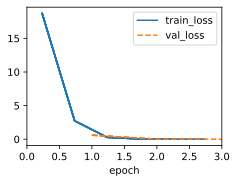

In [7]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Below, we
[**compare the model parameters learned
by training on finite data
and the actual parameters**]
that generated our dataset.
To access parameters,
we access the weights and bias
of the layer that we need.
As in our implementation from scratch,
note that our estimated parameters
are close to their true counterparts.


In [8]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [9]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0052, -0.0063])
error in estimating b: tensor([0.0100])


## Summary

This section contains the first
implementation of a deep network (in this book)
to tap into the conveniences afforded
by modern deep learning frameworks,
such as MXNet :cite:`Chen.Li.Li.ea.2015`,
JAX :cite:`Frostig.Johnson.Leary.2018`,
PyTorch :cite:`Paszke.Gross.Massa.ea.2019`,
and Tensorflow :cite:`Abadi.Barham.Chen.ea.2016`.
We used framework defaults for loading data, defining a layer,
a loss function, an optimizer and a training loop.
Whenever the framework provides all necessary features,
it is generally a good idea to use them,
since the library implementations of these components
tend to be heavily optimized for performance
and properly tested for reliability.
At the same time, try not to forget
that these modules *can* be implemented directly.
This is especially important for aspiring researchers
who wish to live on the leading edge of model development,
where you will be inventing new components
that cannot possibly exist in any current library.


In PyTorch, the `data` module provides tools for data processing,
the `nn` module defines a large number of neural network layers and common loss functions.
We can initialize the parameters by replacing their values
with methods ending with `_`.
Note that we need to specify the input dimensions of the network.
While this is trivial for now, it can have significant knock-on effects
when we want to design complex networks with many layers.
Careful considerations of how to parametrize these networks
is needed to allow portability.


## Exercises

1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch
   with an average over the loss on the minibatch?
1. Review the framework documentation to see which loss functions are provided. In particular,
   replace the squared loss with Huber's robust loss function. That is, use the loss function
   $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$
1. How do you access the gradient of the weights of the model?
1. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?
1. How does the solution change as you vary the amount of data generated?
    1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
    2. Why is the suggestion in the hint appropriate?


1

默认：loss = sum ⇒ 梯度大

若改为：loss = mean ⇒ 梯度小 batch_size 倍

为保持效果，需将学习率乘以 batch_size


2

error in estimating w: tensor([ 1.4426, -2.4224])
error in estimating b: tensor([2.1347])


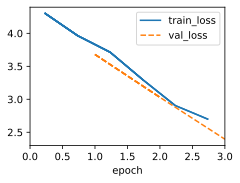

In [22]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    # Define the Huber loss function
    def huber_loss(y_true, y_pred, sigma=1.0):
        error = torch.abs(y_true - y_pred)
        quadratic = 0.5 * (error / sigma)**2
        linear = error - 0.5 * sigma
        return torch.where(error > sigma, linear, quadratic)

    # Return the mean of the Huber losses
    return torch.mean(huber_loss(y.reshape(-1, 1), y_hat))

model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

w, b = model.get_w_b()
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

3

In [23]:
print("权重梯度：", model.net.weight.grad)
print("偏置梯度：", model.net.bias.grad)

权重梯度： tensor([[0.1282, 0.8100]])
偏置梯度： tensor([-0.3109])


4

  Learning Rate: 0.5, Epochs: 20
  Error in estimating w: 0.0014872947940602899
  Error in estimating b: tensor([0.0006])
--------------------


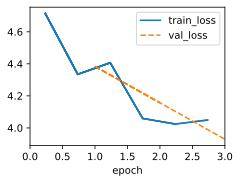

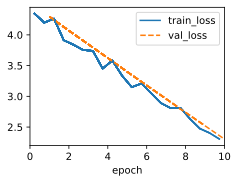

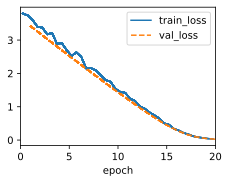

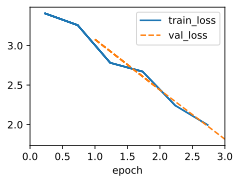

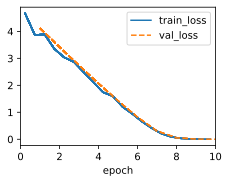

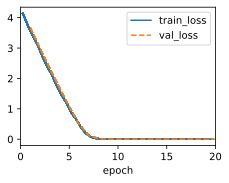

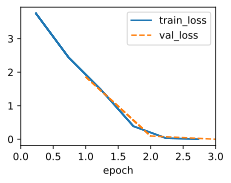

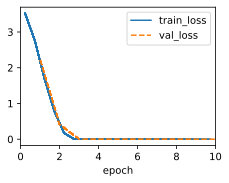

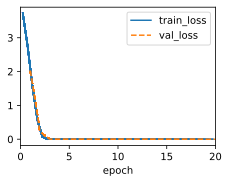

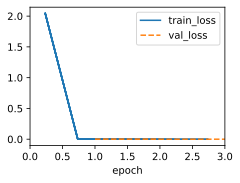

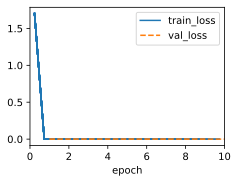

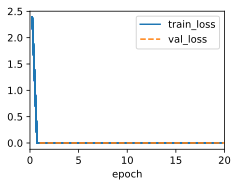

In [28]:
# prompt: What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?
# 如果您更改学习率和 epoch 数，对解决方案有什么影响？它会不断改进吗？

def train_and_evaluate(lr, num_epochs):
    model = LinearRegression(lr=lr)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
    trainer = d2l.Trainer(max_epochs=num_epochs)
    # The fit method returns a list of losses, one for each epoch.
    # However, d2l.Trainer doesn't expose the history directly in this way.
    # We can manually track the loss during training if needed,
    # but the primary effect to observe is the final error and
    # the training loss shown during the fit call.
    trainer.fit(model, data)

    w, b = model.get_w_b()
    w_error = torch.norm(data.w - w.reshape(data.w.shape))
    b_error = torch.abs(data.b - b)
    print(f'  Learning Rate: {lr}, Epochs: {num_epochs}')
    print(f'  Error in estimating w: {w_error}')
    print(f'  Error in estimating b: {b_error}')
    print("-" * 20)

# Explore different learning rates and epochs
learning_rates = [0.01, 0.03, 0.1, 0.5]
num_epochs_list = [3, 10, 20]

for lr in learning_rates:
    for epochs in num_epochs_list:
        print(f"Training with LR={lr}, Epochs={epochs}")
        train_and_evaluate(lr, epochs)

# Analysis:
# - Changing the learning rate and the number of epochs significantly affects the solution.
# - A higher learning rate can lead to faster convergence initially but might overshoot the optimal solution or oscillate. A very high learning rate can cause the loss to explode (divergence).
# - A lower learning rate converges slower but might find a more precise solution if given enough epochs.
# - Increasing the number of epochs generally leads to improvement as the model has more time to learn, *given a suitable learning rate*. However, after a certain point, the improvement might become negligible, or the model could potentially overfit if the dataset is small (though less likely with a simple linear model).
# - It doesn't necessarily keep on improving indefinitely. There's a point where increasing epochs or changing the learning rate further might not yield significant improvements or could even worsen the result (e.g., due to overfitting or divergence with high LR).
# - The goal is to find a combination of learning rate and epochs that minimizes the loss on the training data and generalizes well (though we aren't evaluating generalization here). The final error values for w and b estimation provide a measure of how well the model learned the underlying parameters.


5.1

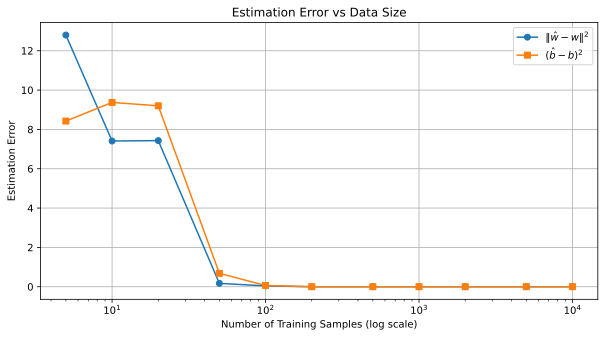

In [43]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# 生成合成数据
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# 模型训练并返回估计误差
def train_and_get_error(n, true_w, true_b):
    X, y = synthetic_data(true_w, true_b, n)
    net = nn.Sequential(nn.Linear(len(true_w), 1))
    net[0].weight.data.normal_(0, 0.01)
    net[0].bias.data.fill_(0)

    loss = nn.MSELoss()
    trainer = torch.optim.SGD(net.parameters(), lr=0.03)
    data_iter = d2l.load_array((X, y), batch_size=10)

    for epoch in range(5):
        for X_batch, y_batch in data_iter:
            l = loss(net(X_batch), y_batch)
            trainer.zero_grad()
            l.backward()
            trainer.step()

    w_est = net[0].weight.data.reshape(-1)
    b_est = net[0].bias.data
    w_error = ((w_est - true_w) ** 2).sum().item()
    b_error = ((b_est - true_b) ** 2).item()
    return w_error, b_error

# 设置真实参数
true_w = torch.tensor([2.0, -3.4])
true_b = 4.2

# 设置对数增长的样本数量
sample_sizes = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
w_errors = []
b_errors = []

# 收集误差
for n in sample_sizes:
    w_err, b_err = train_and_get_error(n, true_w, true_b)
    w_errors.append(w_err)
    b_errors.append(b_err)

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, w_errors, 'o-', label=r'$\|\hat{w} - w\|^2$')
plt.plot(sample_sizes, b_errors, 's-', label=r'$(\hat{b} - b)^2$')
plt.xscale('log')
plt.xlabel('Number of Training Samples (log scale)')
plt.ylabel('Estimation Error')
plt.title('Estimation Error vs Data Size')
plt.grid(True)
plt.legend()
plt.show()


5.2

因为：
- 线性增长（如 1000, 2000, ..., 10000）前期变化太慢；
- 对数增长（5, 10, 20...）可以更细致观察小样本下的误差变化趋势；
能更全面观察数据量对模型精度的影响。


[Discussions](https://discuss.d2l.ai/t/45)
